# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd

strategyArray  = []
gainArray      = []
lossArray      = []
channelTypeQnt = 3
ampNumber      = 3

originalDataSet = []
binaryDataSet   = []

gainScalerList = []
lossScalerList = []

originalDataSet.append(pd.read_csv('../datasets/1_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/2_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/4_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))

for i in range(channelTypeQnt):
    binaryDataSet.append([])
    for line in originalDataSet[i].values:
        myList = [1 if i != 0 else 0 for i in line[:40]]
        myList.extend(line[40:])
        binaryDataSet[i].append(myList)

    binaryDataSet[i] = pd.DataFrame(binaryDataSet[i])
    gainScaler       = MinMaxScaler(feature_range = (-1, 1))
    lossScaler       = MinMaxScaler(feature_range = (-1, 1))

    gainScalerAux = []
    lossScalerAux = []
    
    for j in range(0, ampNumber * 2, 2):
        gainScalerAux.extend(binaryDataSet[i].values[:, 40 + j])
        lossScalerAux.extend(binaryDataSet[i].values[:, 40 + j + 1])

    gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
    lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))
    
    gainScalerList.append(gainScaler)
    lossScalerList.append(lossScaler)

def loadDataset(channelIndex): 
    dataSet = binaryDataSet[channelIndex].values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet[channelIndex].values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet[channelIndex].values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScalerList[channelIndex].inverse_transform(auxArray)[0][0]

def invertLossNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScalerList[channelIndex].inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2, channelIndex):
    return abs(invertGainNorm(value1, channelIndex) - invertGainNorm(value2, channelIndex))

def getLossError(value1, value2, channelIndex):
    return abs(invertLossNorm(value1, channelIndex) - invertLossNorm(value2, channelIndex))

features, result = loadDataset(0)

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i], 0) 
                lossError += getLossError(predicted[i + 1], expected[i + 1], 0)
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy, channelIndex):   
    features, result       = loadDataset(channelIndex)
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray[channelIndex].append(gainErrors)
    lossArray[channelIndex].append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotErrorBoxPlots():
    fig, axis = plt.subplots(2, 3, figsize = (10, 5))
    
    p1 = axis[0, 0].boxplot(gainArray[0])
    axis[0, 0].set_ylabel("Gain Absolute Error (dB)", fontsize = 8)
    axis[0, 0].set_ylim([1, 5])
    
    axis[0, 1].boxplot(gainArray[1])
    axis[0, 1].set_ylim([1, 5])
    #axis[0, 1].get_yaxis().set_visible(False)
    
    axis[0, 2].boxplot(gainArray[2])
    axis[0, 2].set_ylim([1, 5])
    #axis[0, 2].get_yaxis().set_visible(False)
    
    axis[1, 0].boxplot(lossArray[0])
    axis[1, 0].set_ylabel("Loss Absolute Error (dB)", fontsize = 8)
    axis[1, 0].set_xlabel("1 channel type", fontsize = 8)
    axis[1, 0].set_ylim([1, 5])
    
    axis[1, 1].boxplot(lossArray[1])
    axis[1, 1].set_xlabel("2 channel type", fontsize = 8)
    axis[1, 1].set_ylim([1, 5])
    #axis[1, 1].get_yaxis().set_visible(False)
    
    axis[1, 2].boxplot(lossArray[2])
    axis[1, 2].set_xlabel("4 channel type", fontsize = 8)
    axis[1, 2].set_ylim([1, 5])
    #axis[1, 2].get_yaxis().set_visible(False)
    
    fig.suptitle("Train error", fontsize = 16)
    fig.legend(p1["boxes"], strategyArray, handlelength = 0, bbox_to_anchor=(0.7, 0.81), loc = "right")
    
    #fix scale
    
    plt.show()

In [6]:
def plotGainDistribution(regressor):
    return
    features, result = loadDataset(channelIndex)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(result[:, 0], 0), vFunc(predicted[:, 0], 0))
    axis.set_title("Gain Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [7]:
def plotLossDistribution(regressor):
    return
    features, result = loadDataset(0)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1], 0), vFunc(predicted[:, 1], 0), c = "m")
    axis.set_title("Loss Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [8]:
gainArray = [[],[],[]]
lossArray = [[],[],[]]

In [9]:
for i in range(channelTypeQnt):
    linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
    trainModel(linearSVR, i)
    
strategyArray.append("1 - SVR (Linear)")
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

[3.34177589 1.50650642 1.74076777 2.43392095 1.88913978] => 2.18 (+/- 1.31)
[2.48908789 2.51969159 2.34991238 1.98329254 1.95394755] => 2.26 (+/- 0.49)
[2.0929283  2.52473948 1.83531803 1.54806623 1.55095855] => 1.91 (+/- 0.74)
[2.32017531 2.44754479 2.0515212  2.43325604 1.40228091] => 2.13 (+/- 0.78)
[2.30966275 2.02691747 1.59239879 2.01591653 1.73110783] => 1.94 (+/- 0.50)
[2.29897867 2.41166369 1.99494501 2.17224313 2.13345991] => 2.20 (+/- 0.29)


In [10]:
for i in range(channelTypeQnt):
    lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
    trainModel(lasso, i)
    
strategyArray.append("2 - Lasso")
plotGainDistribution(lasso)
plotLossDistribution(lasso)

[2.52914018 2.77730581 2.32132602 2.70212385 2.33653191] => 2.53 (+/- 0.37)
[1.84829707 2.22327929 1.89257005 1.89843164 1.4330277 ] => 1.86 (+/- 0.50)
[2.06904142 2.62088822 1.90717889 1.83072458 1.71325535] => 2.03 (+/- 0.64)
[2.34009105 2.23332929 2.33731191 2.43387093 1.51539817] => 2.17 (+/- 0.67)
[2.35924953 2.44443262 2.12116081 2.25883477 2.2068021 ] => 2.28 (+/- 0.23)
[2.15406922 2.33997295 1.89879427 1.91247781 1.9559682 ] => 2.05 (+/- 0.34)


In [11]:
for i in range(channelTypeQnt):
    lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
    trainModel(lars, i)
    
strategyArray.append("3 - LARS")
plotGainDistribution(lars)
plotLossDistribution(lars)

[2.80612454 2.80836952 2.31540246 2.71946073 2.3755051 ] => 2.60 (+/- 0.43)
[2.12119838 2.18576466 1.89840759 1.89219515 1.51305192] => 1.92 (+/- 0.47)
[2.16487554 2.55630219 1.82015112 1.78750399 1.68203748] => 2.00 (+/- 0.64)
[2.28162808 2.22131928 2.20763426 2.34197784 1.39967089] => 2.09 (+/- 0.70)
[2.34520586 2.28020513 1.9329439  2.23111389 2.24605265] => 2.21 (+/- 0.29)
[1.9370181  2.1285657  1.61957325 1.7654703  1.87336286] => 1.86 (+/- 0.34)


In [12]:
for i in range(channelTypeQnt):
    huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
    trainModel(huber, i)
    
strategyArray.append("4 - Huber")
plotGainDistribution(huber)
plotLossDistribution(huber)

[3.4003114  1.01991659 1.20600238 2.36876676 2.0696539 ] => 2.01 (+/- 1.72)
[3.51772344 1.97128242 1.96581829 1.70826203 1.84448393] => 2.20 (+/- 1.33)
[2.23231025 2.50120396 1.47260603 2.92340406 3.13905834] => 2.45 (+/- 1.17)
[2.24024562 2.58156309 1.64793587 2.26366101 1.95069414] => 2.14 (+/- 0.63)
[3.86223852 2.11081848 3.05583815 1.93423967 2.63405092] => 2.72 (+/- 1.39)
[3.87723717 3.09931623 2.47708727 2.22441656 2.21518316] => 2.78 (+/- 1.27)


In [13]:
for i in range(channelTypeQnt):
    knn = MultiOutputRegressor(KNeighborsRegressor())
    trainModel(knn, i)
    
strategyArray.append("5 - KNN")
plotGainDistribution(knn)
plotLossDistribution(knn)

[3.3291954  0.92965517 1.28873563 2.53655172 2.05793103] => 2.03 (+/- 1.72)
[2.25716475 2.20199234 1.70012771 1.70748404 2.01481481] => 1.98 (+/- 0.47)
[1.87409283 2.39054852 1.70835443 1.42194093 1.72523207] => 1.82 (+/- 0.64)
[2.20789498 2.04346929 1.79818097 2.35221753 2.72892639] => 2.23 (+/- 0.62)
[3.09416196 1.80094162 1.35951036 2.63427495 1.44642185] => 2.07 (+/- 1.37)
[2.06160285 2.68349027 1.80774221 2.07558067 1.51830927] => 2.03 (+/- 0.77)


In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

for i in range(channelTypeQnt):
    extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
    bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
    trainModel(bret, i)
    
strategyArray.append("6 - Extra Tree")
plotGainDistribution(bret)
plotLossDistribution(bret)

[3.68523287 0.95431625 1.26905461 2.46191204 2.07347769] => 2.09 (+/- 1.93)
[2.32106063 1.93415915 1.87966181 1.72837581 1.8218785 ] => 1.94 (+/- 0.41)
[1.87675342 2.60297889 1.6529941  1.21026739 1.10712344] => 1.69 (+/- 1.07)
[2.15040716 2.09778314 1.72513709 2.17335304 1.18681811] => 1.87 (+/- 0.75)
[2.81114338 1.6182419  1.08243573 2.10414512 1.65989345] => 1.86 (+/- 1.15)
[2.15257188 1.93808239 1.79295215 2.15274154 1.74891904] => 1.96 (+/- 0.34)


In [15]:
from sklearn.ensemble import RandomForestRegressor

for i in range(channelTypeQnt):
    randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
    trainModel(randomForest, i)

strategyArray.append("7 - Random Forest")
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

[3.68515904 0.95461468 1.26951088 2.45756406 2.07402041] => 2.09 (+/- 1.93)
[2.32146753 1.93492735 1.88375718 1.73098547 1.82259445] => 1.94 (+/- 0.41)
[1.81335158 2.60604377 1.67041601 1.21094092 1.10328476] => 1.68 (+/- 1.07)
[2.24023863 2.25486052 1.73776173 2.17147524 1.14878432] => 1.91 (+/- 0.85)
[2.83070163 1.4976782  1.20911617 2.08796352 1.45009547] => 1.82 (+/- 1.17)
[2.16694023 1.98105271 1.77284377 2.04653747 1.62578393] => 1.92 (+/- 0.39)


# Plotting error boxplots

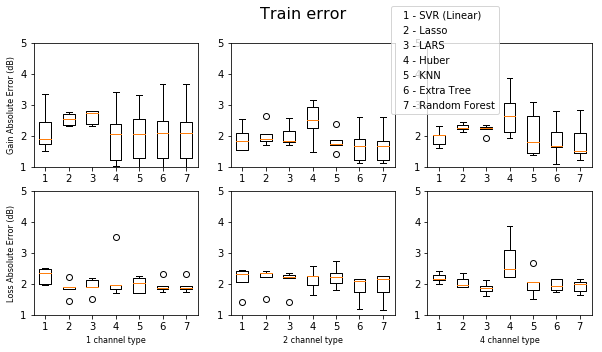

In [16]:
plotErrorBoxPlots()